# New York City Taxi Fare Prediction

The task is to predict the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.  While I can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used. The challenge is to do better than this using Machine Learning techniques!

All datasets and the task itself were taken from the Kaggle playground competition, I do not own any of them.

## Taxi fare prediction analysis - cleaning up the training data


First we need to look at the data:

In [10]:
# load some default Python modules that will be used for all the sections of the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')



In [11]:
# read training data with limiting to the rows, as the file is big

tax_train = pd.read_csv("train.csv", nrows = 10_000, parse_dates=["pickup_datetime"])

#and checking what columns the dataframe has
tax_train.columns.to_list()

['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [12]:
# i can also check how the table would look like and get the shape of the dataframe
print(tax_train.shape)
tax_train.head()

(10000, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
1,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00-73.982738,40.761270,-73.991242,40.750562,2.000000,NaN
2,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42-73.98713,40.733143,-73.991567,40.758092,1.000000,NaN
3,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00-73.968095,40.768008,-73.956655,40.783762,1.000000,NaN
4,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45-74.000964,40.731630,-73.972892,40.758233,1.000000,NaN


I check the type of the data, I will need it later to pick up features for training.

In [13]:
# check datatypes
tax_train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

I check how the data looks like

In [8]:
tax_train.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.0
mean,11.240664,39.908976,-72.462655,39.881789,1.649078,1.0
std,9.594705,7.407082,10.640098,6.441364,1.330502,NaN
min,-2.900000,-74.016048,-74.429332,-73.994392,0.000000,1.0
25%,6.000000,40.734547,-73.991113,40.735220,1.000000,1.0
50%,8.500000,40.752693,-73.980087,40.753736,1.000000,1.0
75%,12.500000,40.767694,-73.963504,40.768182,2.000000,1.0
max,180.000000,401.083332,40.802437,41.366138,40.782004,1.0


As I can see, there is a negative `fare_amount` and some NaN in the `passanger_count` available. I need to clean up the data before I can start training my model. 

So I need to decide if I just drop the missing values, or refill them. To make a descision I need to see how much of them do I have in my set.

In [17]:
# get the number of missing data points per column
missing_values_count = tax_train.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:10]

key                     0
fare_amount             0
pickup_datetime         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
passenger_count      9999
dtype: int64

It looks like a lot, but to make a final descision I will also look how much is that in percentage.

In [18]:
# how many total missing values do we have?
total_cells = np.product(tax_train.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

12.49875


Nearly 12.5%. This looks like a lot to me, so I am not going to drop these rows, but will fill them with the mean data.

In [24]:
#filling NaN with mean
tax_train.fillna(tax_train.mean(), inplace=True)

Now I need to check if there are any NaN left. Looks like no and everything is fine.

In [29]:
# get the number of missing data points per column
missing_values_count = tax_train.isnull().sum()

# look at the # of missing points
print(missing_values_count)

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


Old size: 10000


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

Then I take a look into the test set to see how the columns look like there

In [37]:
# Read test data

tax_test = pd.read_csv("test.csv", nrows = 2_000)

#and checking what columns the data table has
tax_test.columns.to_list()

['key',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [38]:
tax_train.isnull().any()

key                  False
fare_amount          False
pickup_datetime      False
pickup_longitude     False
pickup_latitude      False
dropoff_longitude    False
dropoff_latitude     False
passenger_count       True
dtype: bool

As I can see there is no `fare_amount` column, as I need to predict that column. The rest of the columns are in place.

After looking at the data, I need to determine a problem. I need to determine a model, to understand what kind of Machine Learning model to use.

I start with creating a histogramm of the data:

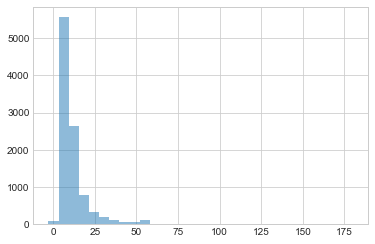

In [9]:
# Plot a histogram
tax_train.fare_amount.hist(bins=30, alpha=0.5)
plt.show()

From histogram I can see, that the `fare_amount` is a contionous variable, therefore I am dealing with the regression problem.

In [40]:
from sklearn.linear_model import LinearRegression


# Creating a LinearRegression object
lr = LinearRegression() 


I take some features in the train set and build a linear regression

In [41]:
# Fit the model on the train data

lr.fit(X=tax_train[['pickup_longitude',  'pickup_latitude',  'dropoff_longitude',  'dropoff_latitude',  'passenger_count']],
        y=tax_train['fare_amount'])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').